In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

This notebook uses the [fastai](https://github.com/fastai/fastai) library. Images from cifar 10 are assumed to be in the folder where PATH points, with a train and a valid subfolders, both of which contains the images from their classes in ten subfolders.

In [2]:
from fastai.conv_learner import *
PATH = Path("../data/cifar/")

Classes and stats

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

Data augmentation: random horizontal flip and reflection padding of 4 pixels.

In [4]:
def get_data(sz,bs):
    tfms = tfms_from_stats(stats, sz, aug_tfms=[RandomFlip()], pad=sz//8)
    return ImageClassifierData.from_paths(PATH, val_name='test', tfms=tfms, bs=bs)

In [5]:
size = 32
batch_size = 512

In [6]:
data = get_data(size,batch_size)

# Resnet-56

Basic bloc of the resnet version for cifar10 (no bottlenecks).

In [7]:
class BasicBlock(nn.Module):
    
    def __init__(self, ch_in, ch_out, stride=1):
        super().__init__()
        self.bn1 = nn.BatchNorm2d(ch_out)
        self.conv1 = nn.Conv2d(ch_in, ch_out, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(ch_out)
        self.conv2 = nn.Conv2d(ch_out, ch_out, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or ch_in != ch_out:
            self.shortcut = nn.Sequential(
                nn.Conv2d(ch_in, ch_out, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(ch_out)
            )

    def forward(self, x):
        shortcut = self.shortcut(x) if hasattr(self, 'shortcut') else x
        out = self.conv1(x)
        out = self.bn2(self.conv2(F.relu(self.bn1(out))))
        out += shortcut
        return F.relu(out)

Resnet for cifar10 with 56 convolutional layers.

In [8]:
class ResNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self.make_group_layer(16, 16, num_blocks[0], stride=1)
        self.layer2 = self.make_group_layer(16, 32, num_blocks[1], stride=2)
        self.layer3 = self.make_group_layer(32, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def make_group_layer(self,ch_in, ch_out, num_blocks, stride):
        layers = [BasicBlock(ch_in, ch_out, stride)]
        for i in range(num_blocks-1):
            layers.append(BasicBlock(ch_out, ch_out, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.adaptive_avg_pool2d(out, 1)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

Let's wrap our model into the fastai library to get all the functions it can offer.

In [9]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss

Learning Rate Finder:

In [13]:
learn.lr_find(wds=1e-4,end_lr=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 95%|█████████▍| 93/98 [00:49<00:02,  1.88it/s, loss=57.8]

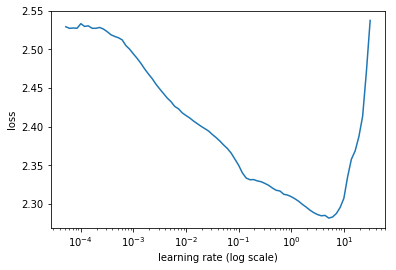

In [15]:
learn.sched.plot(10,1)

In his experiments, Leslie used a maximum learning rate going from 0.8, which is one tenth of the point where the loss starts to increase a lot, to 3.

Let's begin with 0.8 and we'll try more aggressive values next.

# Experiment 1:

Learning rate max: 0.8, 1 cycle of length 95 with 1e-4 of weight decays. The arguments of the use_clr_beta tuples mean:
- pick 1/10th of the maximum learning rate for the minimum learning rate
- dedicate 13.68% of the cycle to the annealing at the end (that's 13 epochs over 95)
- maximum momentum 0.95
- minimum momentum 0.85

In [16]:
learn.fit(0.8,1,cycle_len=95,use_clr_beta=(10,13.68,0.95,0.85),wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=95), HTML(value='')))

 13%|█▎        | 13/98 [00:07<00:51,  1.66it/s, loss=2.35]


Exception in thread Thread-6:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                 
    0      1.731255   1.976543   0.3423    
    1      1.389695   1.495385   0.4746                   
    2      1.157697   1.314696   0.5552                   
    3      0.98268    1.240293   0.5995                    
    4      0.858819   1.186947   0.5945                    
    5      0.763717   0.957801   0.6819                    
    6      0.694522   0.959029   0.6931                    
    7      0.636461   0.73109    0.7535                    
    8      0.581106   0.846448   0.7234                    
    9      0.548038   0.67407    0.7713                    
    10     0.52287    0.875941   0.6953                    
    11     0.486312   0.656722   0.7904                    
    12     0.48089    0.729687   0.7678                    
    13     0.449711   0.589322   0.8026                    
    14     0.426133   0.655264   0.7857                    
    15     0.41602    0.521658   0.8206                    

[0.2691092479467392, 0.9353000002861023]

Error of the original paper was 6.97% in 64K iterations, we got 6.47% in 9,310 (though their true batch size was 256, not 512).

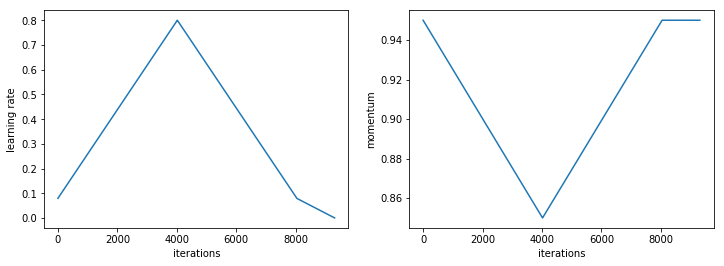

In [17]:
learn.sched.plot_lr()

Learning rate and moment schedules.

Text(0,0.5,'Accuracy')

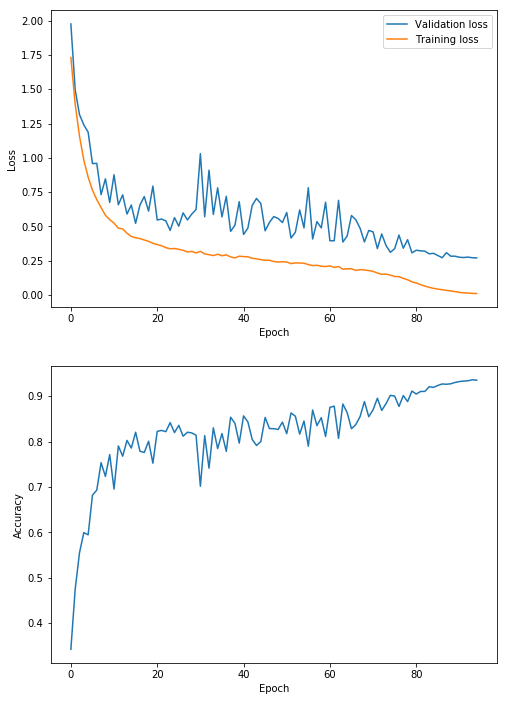

In [27]:
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(95)),learn.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(95)),[learn.sched.losses[i] for i in range(97,95*98,98)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(95)),learn.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

Validation and training loss, accuracy.

# Experiment 2: a smaller cycle

Let's do the same number of iterations, but with a smaller circle and a longer period spent annealing the learning rate.

In [10]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.fit(0.8,1,cycle_len=95,use_clr_beta=(10,50,0.95,0.85),wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=95), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.724663   1.673418   0.3735    
    1      1.458918   1.410227   0.4682                   
    2      1.214657   1.202496   0.5671                   
    3      1.044058   1.228527   0.5737                   
    4      0.872872   0.923806   0.6761                    
    5      0.772582   0.835818   0.706                     
    6      0.695277   0.946446   0.6834                    
    7      0.638265   0.857235   0.7157                    
    8      0.592897   0.830636   0.7176                    
    9      0.557682   0.685772   0.7678                    
    10     0.537554   0.813215   0.7236                    
    11     0.504273   1.041451   0.6829                    
    12     0.480956   0.654285   0.7852                    
    13     0.467005   0.67438    0.77                      
    14     0.437738   0.624808   0.7945                    
    15     0.429075   0.758339   0.7705                    


[0.35398375129699705, 0.9258000001907348]

This doesn't give us the same accuracy or the same validation loss. So it's best to do a longer cycle than try to finetune a smaller one.

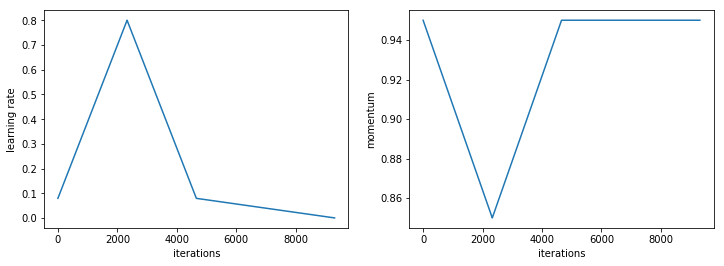

In [11]:
learn.sched.plot_lr()

Text(0,0.5,'Accuracy')

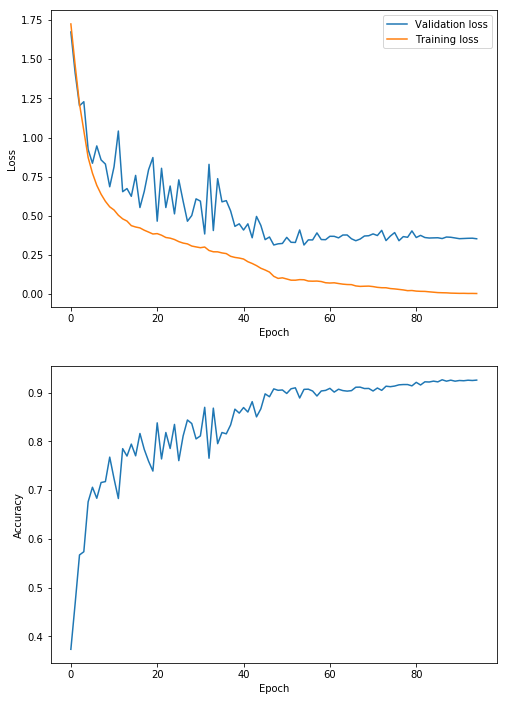

In [12]:
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(95)),learn.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(95)),[learn.sched.losses[i] for i in range(97,95*98,98)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(95)),learn.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

# Experiment 3: A more aggressive learning rate

Let's now try a higher learning rate. Since it will allow the network to train faster, we can use a cycle that is shorter. 

In [22]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.fit(3,1,cycle_len=50,use_clr_beta=(20,10,0.95,0.85),wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=50), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.788645   1.978369   0.3355    
    1      1.509248   1.553127   0.4141                   
    2      1.267367   1.344667   0.5433                   
    3      1.059807   1.440162   0.5513                   
    4      0.898665   0.973891   0.6547                    
    5      0.808841   2.496657   0.4446                    
    6      0.734894   1.185408   0.6359                    
    7      0.684339   1.213519   0.664                     
    8      0.646012   0.85996    0.7035                    
    9      0.625068   0.758049   0.7397                    
    10     0.622004   0.757977   0.761                     
    11     0.586375   0.986663   0.6691                    
    12     0.580766   1.249682   0.622                     
    13     0.557903   1.090958   0.685                     
    14     0.544213   0.842032   0.724                     
    15     0.536944   0.818396   0.7227                    


[0.2424789802789688, 0.9231000001907349]

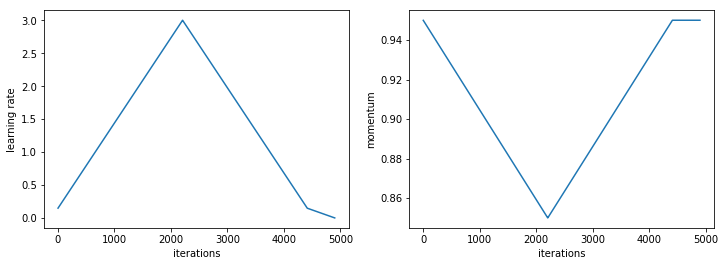

In [23]:
learn.sched.plot_lr()

Text(0,0.5,'Accuracy')

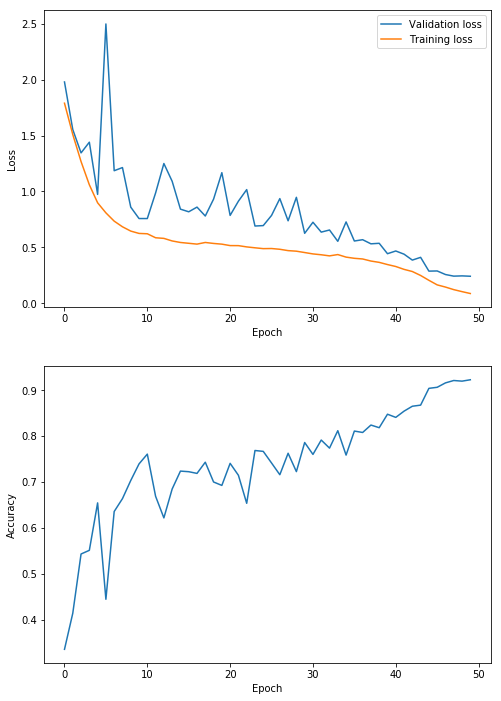

In [27]:
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(50)),learn.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(50)),[learn.sched.losses[i] for i in range(97,50*98,98)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(50)),learn.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

longer

In [28]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.fit(3,1,cycle_len=70,use_clr_beta=(20,10,0.95,0.85),wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=70), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.800825   1.796719   0.3076    
    1      1.546279   1.621248   0.4368                   
    2      1.312235   1.411419   0.5042                   
    3      1.097549   1.764116   0.4696                   
    4      0.94785    1.247346   0.5946                    
    5      0.84014    0.850061   0.7087                    
    6      0.753705   0.920371   0.6884                    
    7      0.709584   0.801247   0.7313                    
    8      0.639489   0.865628   0.7156                    
    9      0.60659    0.7963     0.7364                    
    10     0.590684   0.774417   0.7467                    
    11     0.565472   0.945422   0.705                     
    12     0.548371   1.449532   0.5679                    
    13     0.533411   0.700041   0.7666                    
    14     0.523812   0.813967   0.7339                    
    15     0.503874   0.726054   0.7631                    


[0.2356213487625122, 0.9308]

Not as good as the first result, but 93% in 70 epochs is still an amazing result.

Text(0,0.5,'Accuracy')

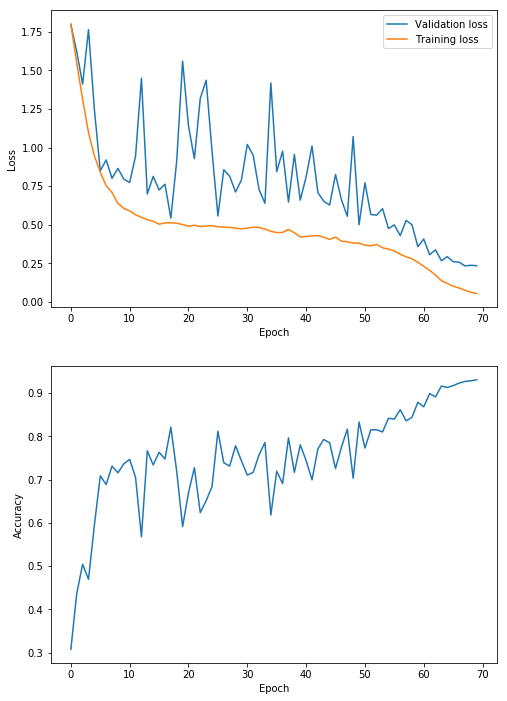

In [30]:
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(70)),learn.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(70)),[learn.sched.losses[i] for i in range(97,70*98,98)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(70)),learn.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

# Experiment 4:

Constant momentum instead of cyclical.

In [18]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.fit(0.8,1,cycle_len=95,use_clr_beta=(10,13.68,0.9,0.9),wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=95), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.63953    1.700311   0.3963    
    1      1.314817   2.172405   0.4157                   
    2      1.055693   1.462401   0.5248                   
    3      0.878954   1.013085   0.676                     
    4      0.773402   1.0066     0.6739                    
    5      0.687668   1.10566    0.634                     
    6      0.634037   1.077911   0.6858                    
    7      0.591956   0.796802   0.7481                    
    8      0.55105    0.950867   0.7064                    
    9      0.522404   0.721647   0.7657                    
    10     0.494421   0.74473    0.75                      
    11     0.482264   0.748897   0.7582                    
    12     0.463911   0.767997   0.7428                    
    13     0.45446    0.632167   0.7939                    
    14     0.43965    1.199145   0.6789                    
    15     0.429272   0.651411   0.7911                    

[0.2914071850776672, 0.9339000002861023]

We get almost the same results as in the run with cyclical momentums in terms of accuracy, though our validation loss isn't as good. 

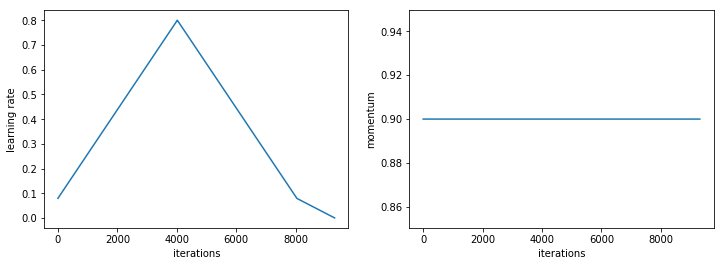

In [19]:
learn.sched.plot_lr()

Text(0,0.5,'Accuracy')

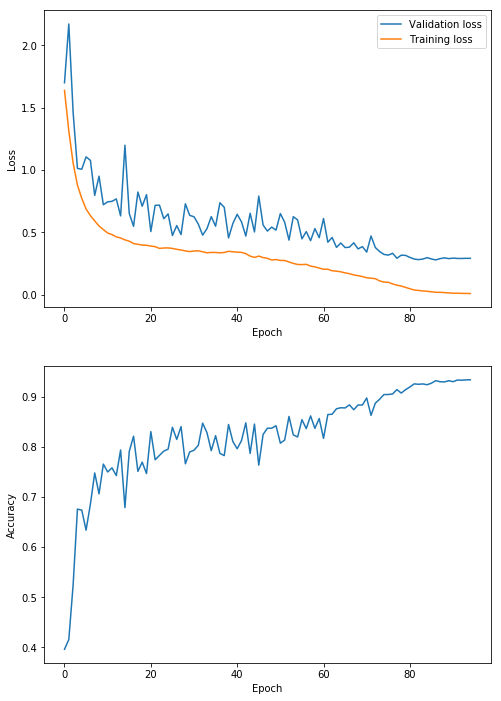

In [20]:
fig,ax = plt.subplots(2,1,figsize=(8,12))
ax[0].plot(list(range(95)),learn.sched.val_losses, label='Validation loss')
ax[0].plot(list(range(95)),[learn.sched.losses[i] for i in range(97,95*98,98)], label='Training loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend(loc='upper right')
ax[1].plot(list(range(95)),learn.sched.rec_metrics)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')

Let's try with a higher learning rate.

In [33]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.fit(3,1,cycle_len=50,use_clr_beta=(20,10,0.9,0.9),wds=1e-4)

HBox(children=(IntProgress(value=0, description='Epoch', max=50), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.777634   3.503059   0.2216    
    1      1.527744   2.15471    0.3165                   
    2      1.246383   1.245104   0.5626                   
    3      1.03158    1.564942   0.5215                   
    4      0.896378   1.306979   0.5724                    
    5      0.794652   1.744486   0.5114                    
    6      0.71283    1.182466   0.6718                    
    7      0.673566   0.893033   0.6911                    
    8      0.63081    1.807354   0.549                     
    9      0.600716   0.817784   0.7247                    
    10     0.58133    0.860469   0.7136                    
    11     0.580077   0.882695   0.7244                    
    12     0.56863    1.219763   0.6308                    
    13     0.57375    1.36282    0.6086                    
    14     0.563426   1.191017   0.6146                    
    15     0.579719   0.817341   0.7129                    


[0.24545099759101868, 0.9225000003814697]

Against the results aren't quite as good, but very close.

# Tuning weight decay

Let's try the learning rate finder with several values of weight decays.

In [79]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.lr_find2(wds=1e-2,start_lr=0.01,end_lr=100,num_it=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  0%|          | 0/98 [00:01<?, ?it/s, loss=2.58]         


Exception in thread Thread-583:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 77%|███████▋  | 75/98 [00:56<00:17,  1.32it/s, loss=8.42]


In [80]:
trn_lossesw2 = learn.sched.losses
val_lossesw2 = learn.sched.val_losses
lrsw2 = learn.sched.lrs

In [100]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.lr_find2(wds=1e-3,start_lr=0.01,end_lr=100,num_it=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

  0%|          | 0/98 [00:00<?, ?it/s]                  


Exception in thread Thread-585:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



 78%|███████▊  | 76/98 [00:57<00:16,  1.33it/s, loss=11.6]


In [101]:
trn_lossesw3 = learn.sched.losses
val_lossesw3 = learn.sched.val_losses
lrsw3 = learn.sched.lrs

In [102]:
learn = ConvLearner.from_model_data(ResNet([9,9,9]), data)
learn.crit = F.nll_loss
learn.lr_find2(wds=1e-4,start_lr=0.01,end_lr=100,num_it=100)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

 87%|████████▋ | 85/98 [01:06<00:10,  1.27it/s, loss=14.3]

In [103]:
trn_lossesw4 = learn.sched.losses
val_lossesw4 = learn.sched.val_losses
lrsw4 = learn.sched.lrs

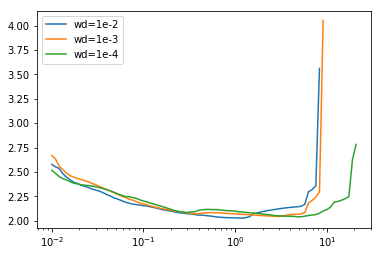

In [113]:
fig, ax = plt.subplots(1,1)
ax.plot(lrsw2[:-1],trn_lossesw2[:-1], label='wd=1e-2')
ax.plot(lrsw3[:-1],trn_lossesw3[:-1], label='wd=1e-3')
ax.plot(lrsw4[:-1],trn_lossesw4[:-1], label='wd=1e-4')
ax.set_xscale('log')
ax.legend(loc='upper left')

And we can see that 1e-4 lets us reach higher learning rates.